In [1]:
# Random Forest Baseline for Satellite Orbit Prediction

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load dataset (CSV version)
file_path = r"starlink_tle_dataset.csv"
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

# 2. Select Features (X) and Target (y)
features = ['Inclination_deg', 'RAAN_deg', 'Eccentricity',
            'Mean_Anomaly_deg', 'Mean_Motion_rev_per_day',
            'Semi_Major_Axis_km', 'Orbital_Period_min']

target = ['Inclination_deg', 'RAAN_deg', 'Eccentricity',
            'Mean_Anomaly_deg', 'Mean_Motion_rev_per_day',
            'Semi_Major_Axis_km', 'Orbital_Period_min']

# Shift target to predict NEXT EPOCH
df_shifted = df.copy()
df_shifted[target] = df_shifted[target].shift(-1)

# Drop last row (NaN after shifting)
df_shifted = df_shifted.dropna()

X = df_shifted[features]
y = df_shifted[target]

# 3. Train-Test Split (time-series with no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 4. Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Predictions
y_pred = model.predict(X_test)

# 6. Evaluation
print("Baseline Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Compare Actual vs Predicted (sample)
comparison = pd.DataFrame({
    "Actual Semi-major Axis": y_test['Semi_Major_Axis_km'].values[:5],
    "Pred Semi-major Axis": y_pred[:5, features.index('Semi_Major_Axis_km')]
})
print("\nSample Predictions (Semi-major axis):")
print(comparison)

Dataset Shape: (8147, 10)
Columns: Index(['Satellite_Name', 'Epoch', 'Inclination_deg', 'RAAN_deg',
       'Eccentricity', 'Argument_of_Perigee_deg', 'Mean_Anomaly_deg',
       'Mean_Motion_rev_per_day', 'Semi_Major_Axis_km', 'Orbital_Period_min'],
      dtype='object')
Baseline Model Performance:
MAE: 3.850451917222713
RMSE: 9.180235151968876
R² Score: 0.4124316522861354

Sample Predictions (Semi-major axis):
   Actual Semi-major Axis  Pred Semi-major Axis
0             6853.556908           6853.628080
1             6853.568205           6853.640957
2             6853.585655           6853.650360
3             6853.573939           6853.623830
4             6853.560723           6853.661896


X shape: (8137, 10, 7)
y shape: (8137, 7)
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0822 - val_loss: 0.0181
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0219 - val_loss: 0.0154
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0177 - val_loss: 0.0146
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0162 - val_loss: 0.0135
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0148 - val_loss: 0.0131
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0146 - val_loss: 0.0125
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0133 - val_loss: 0.0120
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0123 - val_loss: 0.0112
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0119 - val_loss: 0.0108
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0114 - val_loss: 0.010

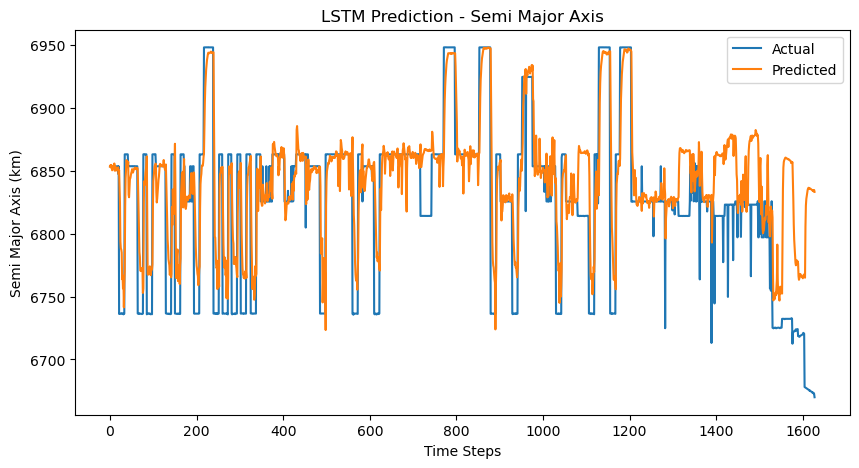

In [2]:
# LSTM Model for Satellite Orbit Prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input

# 1. Load dataset
file_path = "starlink_tle_dataset.csv"
df = pd.read_csv(file_path)

# Select features
features = ['Inclination_deg', 'RAAN_deg', 'Eccentricity',
            'Mean_Anomaly_deg', 'Mean_Motion_rev_per_day',
            'Semi_Major_Axis_km', 'Orbital_Period_min']

data = df[features].values

# 2. Normalize data (scale 0–1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3. Create sequences for LSTM
def create_sequences(data, n_steps=10):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])       # past n_steps
        y.append(data[i+n_steps])         # next step
    return np.array(X), np.array(y)

n_steps = 10  # use last 10 epochs
X, y = create_sequences(data_scaled, n_steps)

print("X shape:", X.shape)  # (samples, n_steps, features)
print("y shape:", y.shape)  # (samples, features)

# 4. Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Build LSTM Model
model = Sequential()
model.add(Input(shape=(n_steps, len(features))))   
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(len(features)))  #output= 7 orbital parameters
model.compile(optimizer='adam', loss='mse')

# 6. Train
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)

# 7. Predictions
y_pred = model.predict(X_test)

# Inverse scale to original values
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# 8. Evaluation
print("LSTM Model Performance:")
print("MAE:", mean_absolute_error(y_test_rescaled, y_pred_rescaled))
print("RMSE:", np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)))
print("R² Score:", r2_score(y_test_rescaled, y_pred_rescaled))

# 9. Visualization (Semi-Major Axis example)
plt.figure(figsize=(10,5))
plt.plot(y_test_rescaled[:, features.index('Semi_Major_Axis_km')], label="Actual")
plt.plot(y_pred_rescaled[:, features.index('Semi_Major_Axis_km')], label="Predicted")
plt.title("LSTM Prediction - Semi Major Axis")
plt.xlabel("Time Steps")
plt.ylabel("Semi Major Axis (km)")
plt.legend()
plt.show()

In [4]:
#hyperparamter tuning 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#data shapes 
if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

#base model random forest
rf_model = RandomForestRegressor(random_state=42)

#parameter grid
param_grid = {
    'n_estimators': [50, 100],       # Number of trees in the forest
    'max_depth': [10, None],         # Depth of each tree
    'min_samples_split': [2, 5],     # Minimum samples required to split
    'min_samples_leaf': [1, 2]       # Minimum samples per leaf
}

#gris search with fewer folds (cv=2 for speed)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=2,              # smaller fold = faster
    n_jobs=-1,         # use all CPU cores
    verbose=2          # show progress
)

#fitting the model where tuning is happening 
grid_search.fit(X_train, y_train)

#results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV Accuracy):", grid_search.best_score_)

#best parameters for final use
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

#evaluate 
test_score = best_rf_model.score(X_test, y_test)
print("Test Accuracy with Best Parameters:", test_score)


Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Score (CV Accuracy): -0.04981527590578376
Test Accuracy with Best Parameters: 0.3666649037503487


In [6]:
#optimized lstm model afte 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

#reshaping input to lstm format(samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], n_steps, len(features)))
X_test = X_test.reshape((X_test.shape[0], n_steps, len(features)))

# lstm model 
model_opt = Sequential()
model_opt.add(Input(shape=(n_steps, len(features))))
model_opt.add(LSTM(128, return_sequences=True))
model_opt.add(Dropout(0.3))
model_opt.add(LSTM(64))
model_opt.add(Dropout(0.3))
model_opt.add(Dense(len(features)))   # output like input features

optimizer = Adam(learning_rate=0.001)
model_opt.compile(optimizer=optimizer, loss='mse')

#training model
history_opt = model_opt.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

#predictions (still scaled)
y_pred_scaled = model_opt.predict(X_test)

#inverse transforming to original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred_scaled)

#evaluation
print("----- Optimized LSTM Performance -----")
print("MAE:", mean_absolute_error(y_test_rescaled, y_pred_rescaled))
print("RMSE:", np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)))
print("R² Score:", r2_score(y_test_rescaled, y_pred_rescaled))


Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0509 - val_loss: 0.0154
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0177 - val_loss: 0.0139
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0147 - val_loss: 0.0117
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 8/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 9/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 10/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 11/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 12/50
367/367 ━━━━━━━━━━━━━━━━━━━

----- Random Forest Model Performance -----
MAE: 0.0699
RMSE: 0.1275
R² Score: 0.3667

Model Comparison:
            Model         MAE        RMSE  R2 Score
0   Random Forest    0.069884    0.127526  0.366665
1  Optimized LSTM  482.698548  891.003067  0.368312


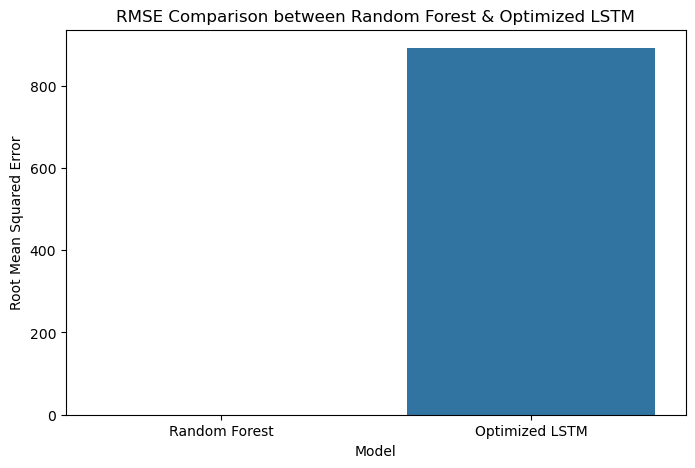

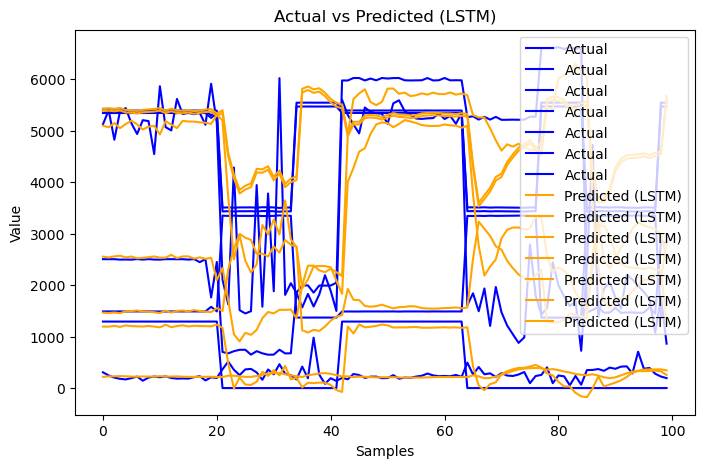

In [17]:
#model comparision and visualization 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#reshape X_test for random forest 
X_test_rf = X_test.reshape(X_test.shape[0], -1)

#predictions using random forest
rf_predictions = best_rf_model.predict(X_test_rf)

#handle scaling 
try:
    rf_pred_rescaled = scaler.inverse_transform(rf_predictions.reshape(-1, 1))
    rf_y_test_rescaled = y_test_rescaled
except:
    rf_pred_rescaled = rf_predictions
    rf_y_test_rescaled = y_test

#evaluate random forest
rf_mae = mean_absolute_error(rf_y_test_rescaled, rf_pred_rescaled)
rf_rmse = np.sqrt(mean_squared_error(rf_y_test_rescaled, rf_pred_rescaled))
rf_r2 = r2_score(rf_y_test_rescaled, rf_pred_rescaled)

print("----- Random Forest Model Performance -----")
print(f"MAE: {rf_mae:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R² Score: {rf_r2:.4f}")

#compare LSTM vs Random Forest visually
models = ['Random Forest', 'Optimized LSTM']
mae_scores = [rf_mae, mean_absolute_error(y_test_rescaled, y_pred_rescaled)]
rmse_scores = [rf_rmse, np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))]
r2_scores = [rf_r2, r2_score(y_test_rescaled, y_pred_rescaled)]

#creating comparison dataframe
comparison_df = pd.DataFrame({
    'Model': models,
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R2 Score': r2_scores
})

print("\nModel Comparison:")
print(comparison_df)

# error comparion visually
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='RMSE', data=comparison_df)
plt.title('RMSE Comparison between Random Forest & Optimized LSTM')
plt.ylabel('Root Mean Squared Error')
plt.show()

#predicted vs actual plot for lstm
plt.figure(figsize=(8, 5))
plt.plot(y_test_rescaled[:100], label='Actual', color='blue')
plt.plot(y_pred_rescaled[:100], label='Predicted (LSTM)', color='orange')
plt.title('Actual vs Predicted (LSTM)')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()
